---
title: LASSO Regression and Tuning in Python
date: 07/30/2023
author:
    -   Yang Chen
    -   Edward Baker
format:
    html:
        code-fold: show
        embed-resources: true
editor:
    render-on-save: true
---

We'll be focus purely on implementing LASSO regression through Python. There's a number of steps that you can take with your data (e.g. association tests, exploratory data analysis) before running straight to LASSO. But something interesting about regularized regression models is how they tend to filter out variables with high pair-wise correlations.

Remember that regularized regression models are just a start in understanding what variables you might want to include--they shouldn't be the final verdict.

# Setup

First, you're going to need to setup your conda environment to install all the packages you will need to do a LASSO regression.

We'll be using the following packages:

-   `pandas` for data collection and manipulation
-   `numpy` for vectorized mathematical operations
-   `sklearn` for the Lasso regression model and train-test splitting
-   `matplotlib` for plotting / visualization capabilities

Note: There is a package called `rpy2` that will allow your to interface with R through Python. However, we won't be using that during the presentation due to potential installation problems for different systems.

In [11]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split

# Data Loading

The Ames Housing dataset is a popular dataset describing characteristics of residential homes in Ames, Iowa. The goal is to predict the selling price of homes.

In [14]:
# Read in the AmesHousing data as a Pandas dataframe
ames = pd.read_csv('ames_housing.csv')
ames.head()
ames.columns

Index(['Unnamed: 0', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area',
       'Street', 'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities',
       'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1',
       'Condition_2', 'Bldg_Type', 'House_Style', 'Overall_Qual',
       'Overall_Cond', 'Year_Built', 'Year_Remod_Add', 'Roof_Style',
       'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type',
       'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1',
       'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'First_Flr_SF',
       'Second_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Finish',
   

# Train-Test Split, Basic Preprocessing

In this scenario, we've run through our initial exploratory analysis to filter our variables down to a subset of the original columns. We're curious to see what variables are selected after fitting a LASSO regression. 

We'll break up our data into training and test sets to keep an honest assessment of our model. Next, we'll do some basic preprocessing and encode our categorical variables as 1's and 0's so we can use them in our model.

In [15]:
# Split our data into train and test sets with a 70-30 split
train, test = train_test_split(ames, test_size=0.3, random_state=123)

# Select specific columns to base our model on
train = train[['Sale_Price', 'Lot_Area', 'Street', 'Bldg_Type', 'House_Style', 'Overall_Qual', 'Roof_Style', 'Central_Air', 'First_Flr_SF', 'Second_Flr_SF', 'Full_Bath', 'Half_Bath', 'Fireplaces', 'Garage_Area', 'Gr_Liv_Area', 'TotRms_AbvGrd']]

# Fill NA values with 0
train = train.fillna(0)

In [16]:
# Reference encode our categorical variables so we can use them in our model
train_dummy = pd.get_dummies(train, columns=['Street', 'Bldg_Type', 'House_Style', 'Overall_Qual', 'Roof_Style', 'Central_Air'])

train_dummy

,Sale_Price,Lot_Area,First_Flr_SF,Second_Flr_SF,Full_Bath,Half_Bath,Fireplaces,Garage_Area,Gr_Liv_Area,TotRms_AbvGrd,...,Overall_Qual_Very_Good,Overall_Qual_Very_Poor,Roof_Style_Flat,Roof_Style_Gable,Roof_Style_Gambrel,Roof_Style_Hip,Roof_Style_Mansard,Roof_Style_Shed,Central_Air_N,Central_Air_Y
2278,130000,43500,2034,0,1,0,0,1041,2034,9,...,False,False,False,True,False,False,False,False,False,True
1379,109900,7162,904,0,1,0,0,408,904,6,...,False,False,False,True,False,False,False,False,False,True
2182,140000,3675,1072,0,1,0,0,525,1072,5,...,False,False,False,True,False,False,False,False,False,True
1436,207500,8998,782,870,2,1,0,532,1652,6,...,False,False,False,True,False,False,False,False,False,True
1599,98000,1477,546,546,2,1,0,0,1092,6,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,193000,8012,1617,0,2,0,1,533,1617,5,...,False,False,False,True,False,False,False,False,False,True
2154,285000,11248,1668,0,2,0,1,702,1668,7,...,False,False,False,False,False,True,False,False,False,True
1766,252000,10790,1108,1277,2,1,1,600,2385,8,...,False,False,False,True,False,False,False,False,False,True
1122,182000,11639,1428,0,2,0,0,480,1428,6,...,False,False,False,True,False,False,False,False,False,True


# Fitting Our Model

Using a LASSO model is super simple in Python. It's just an `sklearn.linear_model` class that can take in an `alpha` argument which represents the penalty multiplier that we use when we fit the model. Here, we'll select an arbitrary LASSO model with `alpha` = 2.0.

In [17]:
# Get our explanatory variable X and our response variable y from the training data
X = train_dummy.loc[:, train_dummy.columns.difference(['Sale_Price'])]
y = train_dummy['Sale_Price']

# Fit a Lasso regression model on our data
# alpha argument is the constant that multiplies the L1 penalty term
ames_lasso = Lasso(alpha = 2.0, max_iter=5000).fit(X, y)

In [18]:
n_alphas = 100
alphas2 = np.logspace(2, 5, n_alphas)
print(alphas2)

coefs2 = []
for a in alphas2:
    lasso = Lasso(alpha = a, max_iter=5000)
    lasso.fit(X, y)
    coefs2.append(lasso.coef_)

[   100.            107.2267222     114.97569954    123.28467394
    132.19411485    141.74741629    151.9911083     162.97508346
    174.75284       187.38174229    200.92330026    215.443469
    231.01297001    247.7076356     265.60877829    284.80358684
    305.38555088    327.45491629    351.11917342    376.49358068
    403.70172586    432.87612811    464.15888336    497.70235643
    533.66992312    572.23676594    613.59072734    657.93322466
    705.48023107    756.46332755    811.13083079    869.74900262
    932.60334688   1000.           1072.26722201   1149.7569954
   1232.84673944   1321.94114847   1417.47416293   1519.91108295
   1629.75083462   1747.52840001   1873.81742286   2009.23300257
   2154.43469003   2310.12970008   2477.07635599   2656.08778295
   2848.03586844   3053.85550883   3274.54916288   3511.19173422
   3764.93580679   4037.0172586    4328.76128108   4641.58883361
   4977.02356433   5336.69923121   5722.36765935   6135.90727341
   6579.33224658   7054.8023

We can plot how our coefficients change at different $\alpha$ levels. Note that as $\alpha$ increases, our coefficients converge to 0 due to increased penalty.

(70.79457843841381, 141253.75446227554, -38261.817192346185, 147672.2544592844)

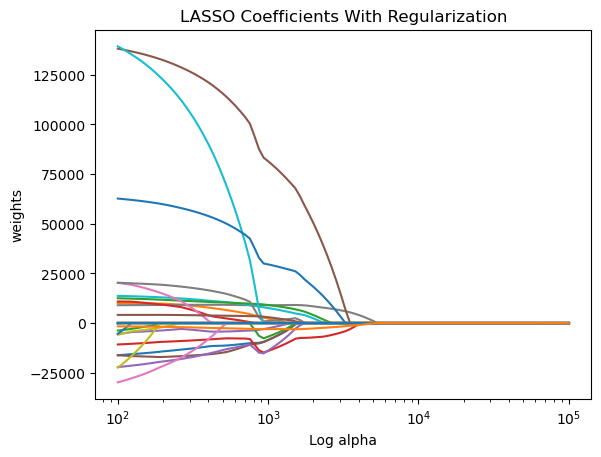

In [20]:
plt.cla()
ax = plt.gca()

ax.plot(alphas2, coefs2)
ax.set_xscale('log')
plt.xlabel('Log alpha')
plt.ylabel('weights')
plt.title('LASSO Coefficients With Regularization')
plt.axis('tight')

# Cross-Validation For Tuning

In [22]:
ames_lasso_cv = LassoCV(cv=10, random_state=123).fit(X, y)

print(f'Chosen alpha: {ames_lasso_cv.alpha_}')
print(f'Weights: {ames_lasso_cv.coef_}')

Chosen alpha: 164867.8496988393
Weights: [-0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.17617224e+01  0.00000000e+00  1.22602736e+02  4.78962745e+01
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -3.14356265e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.79830177e+01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00]


In [23]:
selected_features = pd.Series(ames_lasso_cv.coef_, index=X.columns)
selected_features

Bldg_Type_Duplex                 -0.000000
Bldg_Type_OneFam                  0.000000
Bldg_Type_Twnhs                   0.000000
Bldg_Type_TwnhsE                  0.000000
Bldg_Type_TwoFmCon               -0.000000
Central_Air_N                    -0.000000
Central_Air_Y                     0.000000
Fireplaces                        0.000000
First_Flr_SF                     61.761722
Full_Bath                         0.000000
Garage_Area                     122.602736
Gr_Liv_Area                      47.896274
Half_Bath                         0.000000
House_Style_One_Story             0.000000
House_Style_One_and_Half_Fin     -0.000000
House_Style_One_and_Half_Unf      0.000000
House_Style_SFoyer                0.000000
House_Style_SLvl                 -0.000000
House_Style_Two_Story             0.000000
House_Style_Two_and_Half_Fin     -0.000000
House_Style_Two_and_Half_Unf     -0.000000
Lot_Area                         -0.031436
Overall_Qual_Above_Average       -0.000000
Overall_Qua

In [24]:
selected_features[selected_features != 0]

First_Flr_SF      61.761722
Garage_Area      122.602736
Gr_Liv_Area       47.896274
Lot_Area          -0.031436
Second_Flr_SF     17.983018
dtype: float64

We can see that after running our cross-validation model, we are left with the following variables:

-   First_Flr_SF
-   Garage_Area
-   Gr_Liv_Area
-   Lot_Area
-   Second_Flr_SF